### Leemos el dataset

In [ ]:
import pandas as pd 
import os

ruta = r"C:\Users\uzgre\Codes\Python\Ciencia de Datos\Proyecto_final\Rest-Mex_2025_Train_DataSet"
archivo = os.path.join(ruta, "Rest-Mex_2025_train.csv") 
Data = pd.read_csv(archivo, encoding='latin-1')
print(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208051 entries, 0 to 208050
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Title     208049 non-null  object 
 1   Review    208051 non-null  object 
 2   Polarity  208051 non-null  float64
 3   Town      208051 non-null  object 
 4   Region    208051 non-null  object 
 5   Type      208051 non-null  object 
dtypes: float64(1), object(5)
memory usage: 9.5+ MB
None


In [2]:
Data['Review'][20809] #Ejemplo de una review con malos acentos y caracteres especiales

'Definitivamente un pueblo mÃ¡gico con una arquitectura increÃ\xadble muy bonito y lleno de cultura, comida exquisita y artesanÃ\xadas muy buen lugar para visitar en familia o en pareja...'

### Arreglamos mala lectura de acentos

In [4]:

def arregla_mojibake(texto):
    try:
        return texto.encode('latin1').decode('utf-8')
    except:
        return texto  # Si falla la conversión, deja el texto igual

Data['Title'] = Data['Title'].fillna('').apply(arregla_mojibake)
Data['Review'] = Data['Review'].fillna('').apply(arregla_mojibake)


In [5]:
Data['Review'][20809] # Ahora la review se ve bien

'Definitivamente un pueblo mágico con una arquitectura increíble muy bonito y lleno de cultura, comida exquisita y artesanías muy buen lugar para visitar en familia o en pareja...'

In [ ]:
import numpy as np # type: ignore
np.unique(Data['Type'])

array(['Attractive', 'Hotel', 'Restaurant'], dtype=object)

### Preprocesamiento de texto

In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords

# Asegúrate de tener los stopwords descargados
# nltk.download('stopwords')

stopwords_es = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    texto = texto.lower()  # Minúsculas
    texto = re.sub(r'[^a-záéíóúñü\s]', '', texto)  # Quitar puntuación y caracteres raros
    palabras = texto.split()
    palabras = [palabra for palabra in palabras if palabra not in stopwords_es]  # Remover stopwords
    return ' '.join(palabras)

Data['Texto_Limpio'] = (Data['Title'].fillna('') + ' ' + Data['Review'].fillna('')).apply(limpiar_texto)

### Estimar la dimension adecuada de la representacion de texto

In [8]:
# Calcular la longitud promedio de los textos
longitudes = Data['Texto_Limpio'].apply(len)
longitud_promedio = longitudes.mean()

# Mostrar la longitud promedio
print(f"Longitud promedio de los textos: {longitud_promedio}")

# Usar un múltiplo de la longitud promedio como max_features (ajústalo según tus necesidades)
max_features_optimizado = int(longitud_promedio * 10)  # Ejemplo: multiplicar por 10
print(f"Valor sugerido para max_features: {max_features_optimizado}")


Longitud promedio de los textos: 258.19078495176666
Valor sugerido para max_features: 2581


### Representacion BOW

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

def Representacion_BoW(dataframe):
    """
    Recibe un DataFrame con la columna 'Texto_Limpio'.
    Retorna la matriz BoW como una matriz dispersa.
    """
    vectorizer = CountVectorizer(max_features=2500)
    BoW = vectorizer.fit_transform(dataframe['Texto_Limpio'])  # Transformar los textos
    print(f"Matriz BoW generada con forma: {BoW.shape}")
    return BoW, vectorizer


### Representacion TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore

def Representacion_TF_IDF(dataframe):
    """
    Recibe un DataFrame con la columna 'Texto_Limpio'.
    Retorna la matriz TF-IDF.
    """
    textos = dataframe['Texto_Limpio'].fillna("").values
    
    vectorizer = TfidfVectorizer(
        max_features=2500,
        ngram_range=(1, 2),
        token_pattern=r'(?u)\b[^\d\W]+\b'
    )
    
    X_tfidf = vectorizer.fit_transform(textos)
    
    print(f"Matriz TF-IDF generada con forma: {X_tfidf.shape}")
    return X_tfidf, vectorizer


### Como ver que palabra es cada indice?

In [14]:
feature_names = vectorizer.get_feature_names_out()
print(feature_names[9])  # Te dice qué palabra es la 2911

# Revisa un ejemplo de las palabras más importantes
print(feature_names[:10])


abundantes
['abajo' 'abierta' 'abierto' 'abre' 'abril' 'abrir' 'absolutamente'
 'absoluto' 'abundante' 'abundantes']


### Representacion Word2Vec

In [24]:
from gensim.models import Word2Vec
import numpy as np

def obtener_word2vec_promedio(dataframe):
    """
    Obtiene un vector promedio de Word2Vec para cada texto.
    """
    textos = dataframe['Texto_Limpio'].fillna("").values
    # Entrenar un modelo Word2Vec
    model = Word2Vec(sentences=textos, vector_size=100, window=5, min_count=1, workers=4)
    
    # Crear el vector promedio para cada documento
    def obtener_vector_promedio(texto):
        vectores = [model.wv[word] for word in texto if word in model.wv]
        if len(vectores) == 0:
            return np.zeros(model.vector_size)
        return np.mean(vectores, axis=0)
    
    return np.array([obtener_vector_promedio(texto) for texto in textos])

### Representacion Doc2Vec

In [36]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np

def obtener_doc2vec(dataframe, vector_size=100, epochs=40):
    """
    Genera vectores de Doc2Vec para cada texto del DataFrame.
    """
    textos = dataframe['Texto_Limpio'].fillna("").values

    # Preparamos los documentos con tags requeridos por Doc2Vec
    documentos_tagged = [TaggedDocument(words=texto, tags=[str(i)]) for i, texto in enumerate(textos)]

    # Entrenamos el modelo Doc2Vec
    model = Doc2Vec(vector_size=vector_size, window=5, min_count=1, workers=4, epochs=epochs)
    model.build_vocab(documentos_tagged)
    model.train(documentos_tagged, total_examples=model.corpus_count, epochs=model.epochs)

    # Obtenemos el vector de cada documento
    vectores_doc2vec = np.array([model.dv[str(i)] for i in range(len(textos))])

    print(f"Matriz Doc2Vec generada con forma: {vectores_doc2vec.shape}")
    return vectores_doc2vec, model


### Vistazo a los datos en baja dimension

### PCA en 3D

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse import issparse

def aplicar_PCA(X_tfidf, Data):
    """
    Aplica PCA a los datos y visualiza los primeros tres componentes principales,
    coloreando según la polaridad de los textos.
    """
    # Tomamos el 10% de la muestra y sincronizamos la polaridad
    sample_frac = 0.1
    sample_size = int(X_tfidf.shape[0] * sample_frac)

    # Nos aseguramos de muestrear de forma consistente
    Data_sample = Data.sample(n=sample_size, random_state=42)
    X_sample = X_tfidf[Data_sample.index]

    # Normalizamos los datos sin centrar (importante para matrices dispersas)
    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X_sample)

    # Aplicamos PCA en 3 componentes
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Visualización 3D con colores según polaridad
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
        c=Data_sample['Polarity'], cmap='coolwarm', edgecolor='k', alpha=0.7
    )
    ax.set_title('PCA - Componentes principales (3D)')
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    ax.set_zlabel('Componente 3')

    # Colorbar para entender la escala de polaridad
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Polarity')

    plt.show()

    # Mostrar la varianza explicada
    print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_}")

### PCA en 3D por 'Type'

In [27]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.sparse import issparse

def aplicar_PCA_por_tipo(X_tfidf, Data):
    """
    Aplica PCA y visualiza los tres primeros componentes principales
    coloreando según la columna 'Type' (Attractive, Hotel, Restaurant).
    """
    # Muestreo sincronizado
    sample_frac = 0.1
    sample_size = int(X_tfidf.shape[0] * sample_frac)

    Data_sample = Data.sample(n=sample_size, random_state=42)
    X_sample = X_tfidf[Data_sample.index]

    # Normalización
    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X_sample)

    # PCA a 3 componentes
    pca = PCA(n_components=3, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Preparar mapeo de categorías a números
    type_labels, uniques = pd.factorize(Data_sample['Type'])
    colors = ListedColormap(['#1f77b4', '#2ca02c', '#d62728'])  # Azul, verde, rojo
    #print(type_labels)

    # Gráfica
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
        c=type_labels, cmap=colors, edgecolor='k', alpha=0.7
    )
    ax.set_title('PCA - Componentes principales (3D) por Tipo')
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    ax.set_zlabel('Componente 3')

    # Leyenda personalizada
    legend_labels = uniques
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          label=label,
                          markerfacecolor=colors.colors[i],
                          markersize=10, markeredgecolor='k')
               for i, label in enumerate(legend_labels)]
    ax.legend(handles=handles, title='Type')

    plt.show()

    # Mostrar la varianza explicada
    print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_}")
    

### Veamos PCA con TF-IDF

Matriz TF-IDF generada con forma: (208051, 2500)


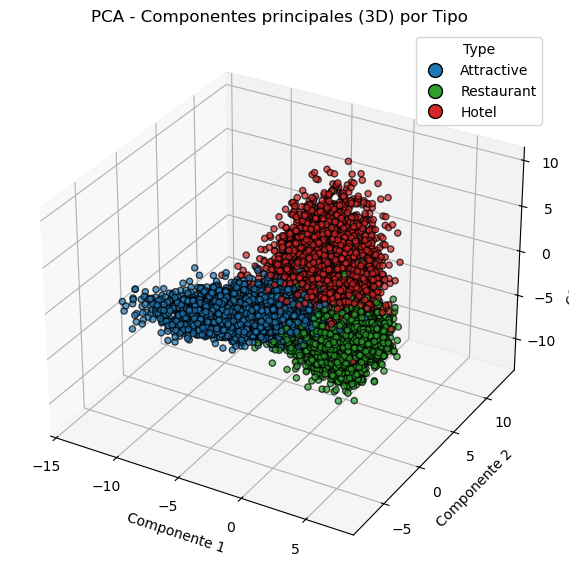

Varianza explicada por PCA: [0.00360068 0.00294857 0.00240551]


In [35]:
X_tfidf, vectorizer = Representacion_TF_IDF(Data)
aplicar_PCA_por_tipo(X_tfidf, Data)

### Veamos PCA con BoW

Matriz BoW generada con forma: (208051, 2500)


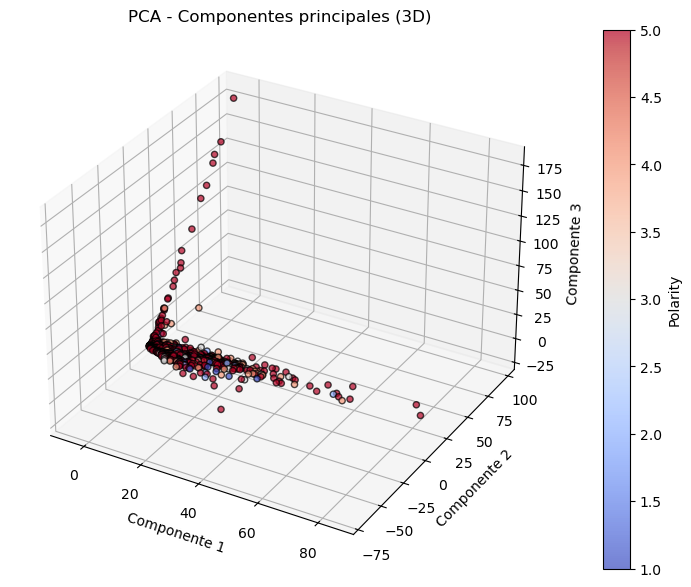

Varianza explicada por PCA: [0.00696309 0.00383661 0.00376145]


In [18]:
X_Bow, vectorizer = Representacion_BoW(Data)
BoW_dense =X_Bow.toarray()

aplicar_PCA(BoW_dense, Data)

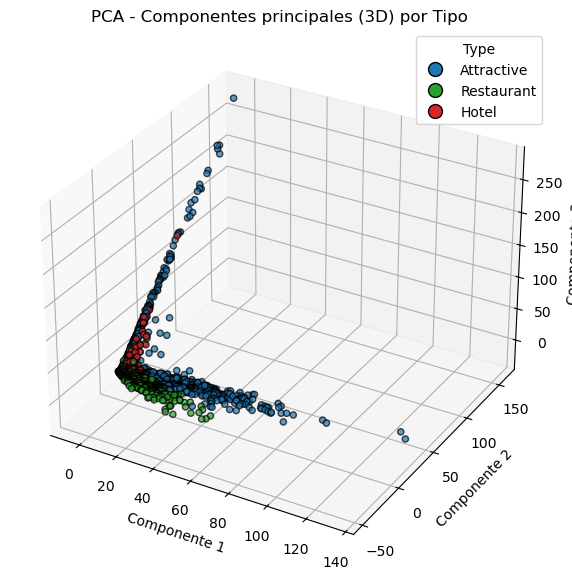

Varianza explicada por PCA: [0.00663572 0.00366617 0.00362013]


In [27]:
aplicar_PCA_por_tipo(BoW_dense, Data)

### Veamos PCA con Word2Vec

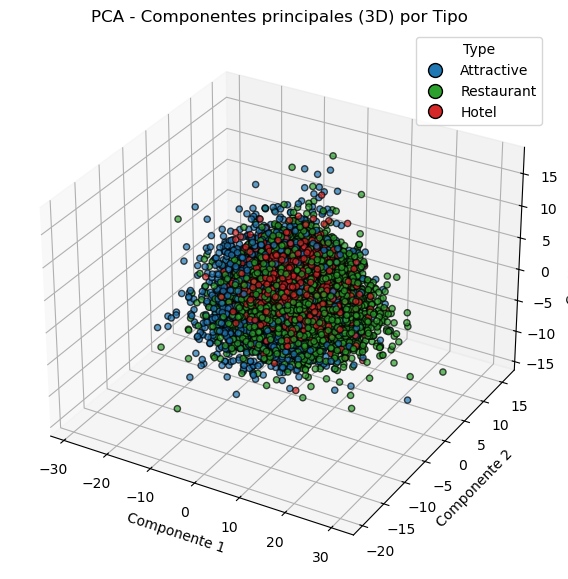

Varianza explicada por PCA: [0.28283602 0.10615832 0.09554362]


In [ ]:
X_word2vec = obtener_word2vec_promedio(Data) 
aplicar_PCA_por_tipo(X_word2vec, Data)

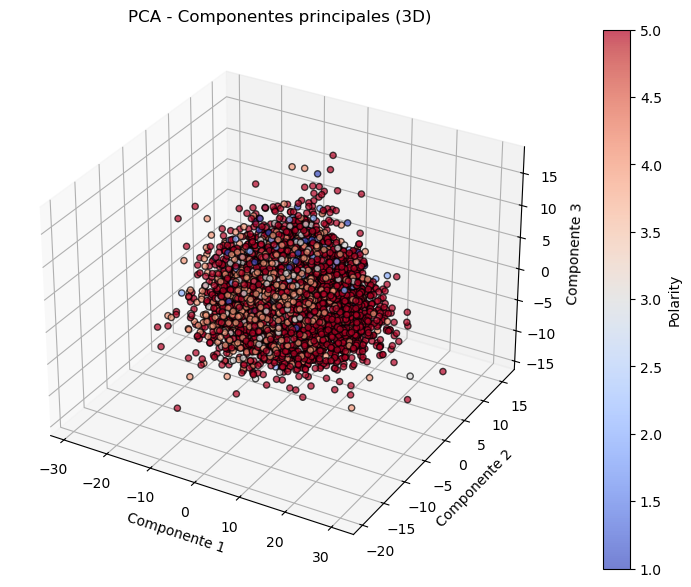

Varianza explicada por PCA: [0.28283602 0.10615832 0.09554362]


In [40]:
aplicar_PCA(X_word2vec, Data)

### Veamos PCA con Doc2Vec

Matriz Doc2Vec generada con forma: (208051, 100)


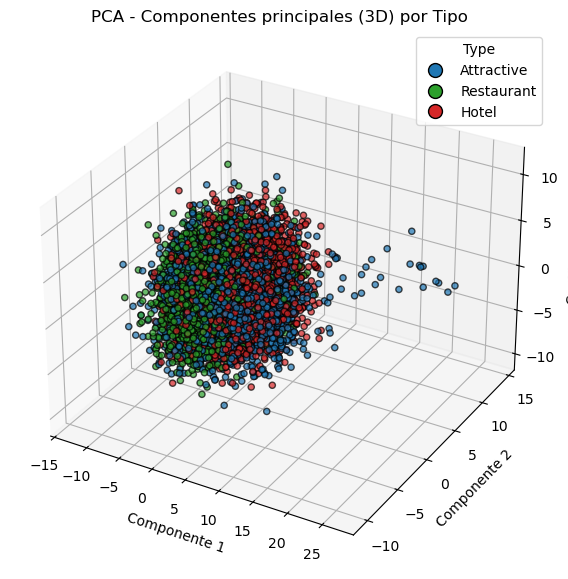

Varianza explicada por PCA: [0.09112009 0.06409065 0.05959937]


In [37]:
X_doc2vec, modelo_doc2vec = obtener_doc2vec(Data)
aplicar_PCA_por_tipo(X_doc2vec, Data)

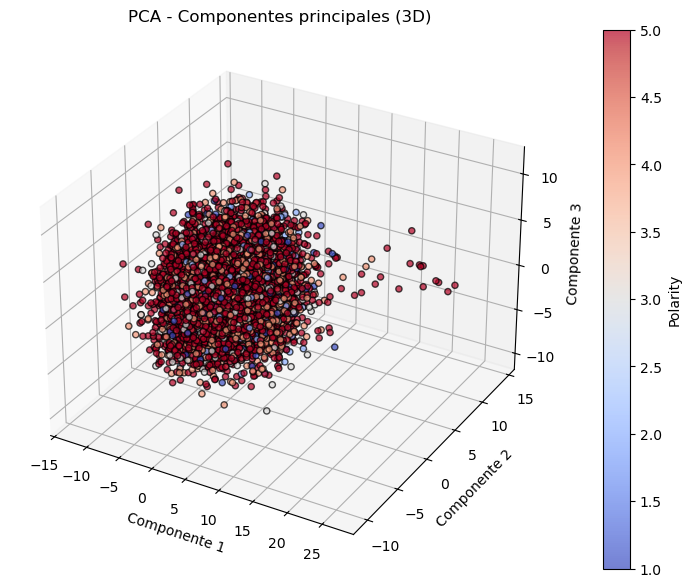

Varianza explicada por PCA: [0.09112009 0.06409065 0.05959937]


In [38]:
aplicar_PCA(X_doc2vec, Data)

In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

def aplicar_tSNE(X, Data):
    """
    Aplica t-SNE para reducir la dimensionalidad de los datos a 2 dimensiones
    y visualiza el resultado usando 'Polarity' como color.
    """
    # Tamaño de la muestra
    sample_size = int(X.shape[0] * 0.1)
    
    if issparse(X):
        X_sample = X[:sample_size]
        polarity_sample = Data['Polarity'].iloc[:sample_size]
    else:
        sampled_indices = np.random.choice(X.shape[0], sample_size, replace=False)
        X_sample = X[sampled_indices]
        polarity_sample = Data['Polarity'].iloc[sampled_indices]

    # Normalizamos los datos
    scaler = StandardScaler(with_mean=False)  # No centrar si es dispersa
    X_scaled = scaler.fit_transform(X_sample)

    # Reducimos dimensionalidad con PCA antes de t-SNE
    pca = PCA(n_components=min(50, X_scaled.shape[1]))  # Cuida que n_components no exceda features
    X_pca = pca.fit_transform(X_scaled)

    # Aplicamos t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_pca)

    # Visualización
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                          c=polarity_sample, cmap='coolwarm', edgecolor='k', alpha=0.6)
    plt.title('t-SNE de los datos reducidos (Coloreado por Polarity)')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.colorbar(scatter, label='Polarity')
    plt.show()



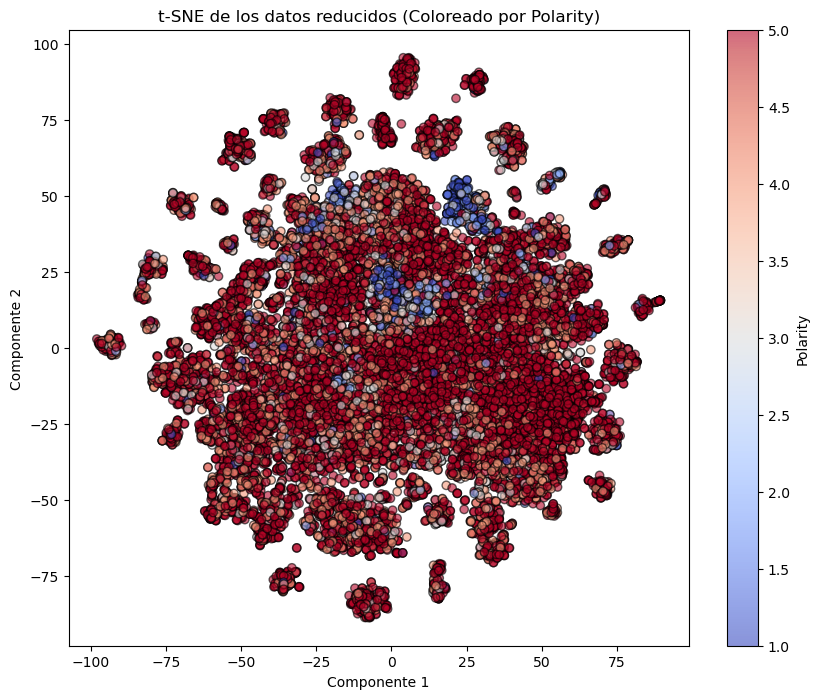

In [23]:
aplicar_tSNE(X_tfidf, Data)
